In [20]:
import quimb.tensor as qtn
import quimb as qu
import torch
L = 4
D = 2

random_peps = qtn.PEPS.rand(L, L, D, phys_dim=2, seed=42)
random_peps.apply_to_arrays(lambda x: torch.tensor(x, dtype=torch.float64))

ham = qtn.ham_2d_heis(L, L, j=1.0, cyclic=False)
ham.apply_to_arrays(lambda x: torch.tensor(x, dtype=torch.float64))

random_peps.compute_local_expectation(ham.terms, normalized=True, max_bond=64)

tensor(0.1413, dtype=torch.float64)

In [18]:
# ED
# E = qu.groundenergy(qu.ham_heis_2D(L, L, j=1.0, cyclic=False))
E = -9.189207065192974

In [56]:
su = qtn.SimpleUpdateGen(
    random_peps,
    ham,
    D=D,
    second_order_reflect=True,
    compute_energy_every=25,
    compute_energy_fn = lambda su: su.get_state().compute_local_expectation(ham.terms, normalized=True, max_bond=64),
    plot_every=10,
)

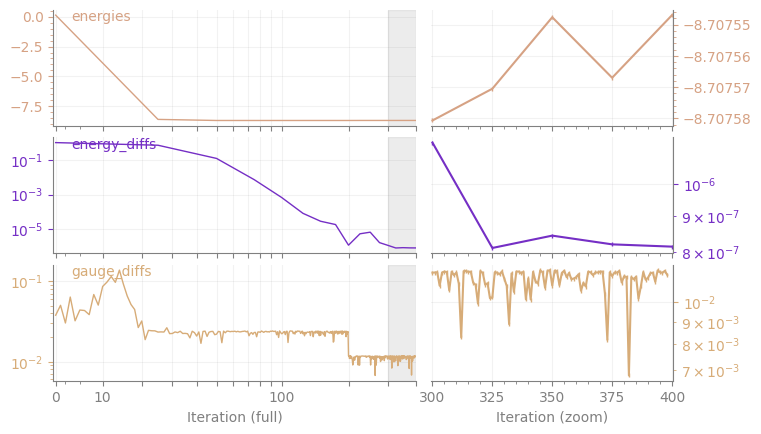

n=400, D=2, tau=0.05, max|dS|=0.0115, energy≈-8.70755: 100%|##########| 200/200 [00:20<00:00,  9.57it/s]


In [58]:
su.evolve(200, tau=0.1)
su.evolve(200, tau=0.05)

In [54]:
import pickle
su.assemble_plot_data()
with open(f"./2D/circuitTNF_heis2D_L{L}_D{D}_plot.pkl", "wb") as f:
    pickle.dump(su.assemble_plot_data(), f)
with open(f"./2D/circuitTNF_heis2D_L{L}_D{D}_su_state.pkl", "wb") as f:
    params, skeleton = qtn.pack(su.get_state())
    pickle.dump((params, skeleton), f)

In [57]:
su.ordering()

(((0, 0), (1, 0)),
 ((1, 2), (2, 2)),
 ((0, 1), (0, 2)),
 ((0, 3), (1, 3)),
 ((1, 1), (2, 1)),
 ((2, 0), (3, 0)),
 ((3, 2), (3, 3)),
 ((1, 0), (2, 0)),
 ((2, 1), (2, 2)),
 ((0, 1), (1, 1)),
 ((3, 1), (3, 2)),
 ((1, 2), (1, 3)),
 ((0, 2), (0, 3)),
 ((2, 3), (3, 3)),
 ((0, 2), (1, 2)),
 ((2, 0), (2, 1)),
 ((1, 0), (1, 1)),
 ((2, 2), (2, 3)),
 ((0, 0), (0, 1)),
 ((3, 0), (3, 1)),
 ((1, 3), (2, 3)),
 ((2, 2), (3, 2)),
 ((1, 1), (1, 2)),
 ((2, 1), (3, 1)))

In [73]:
def form_gated_tns_tnf(
    tns,
    ham,
    depth,
    tau=0.5,
    nn_where_list=None,
    x_tag_id="ROUND_{}",
    y_tag_id="I{}",
    site_tag_id="I{},{}",
):
    tns1 = tns.copy()

    if not isinstance(nn_where_list, list) and not isinstance(nn_where_list, tuple):
        Warning(
            "nn_where_list is not a list of tuples, using all nearest neighbor terms in the Hamiltonian"
        )
        nn_where_list = [(i, i + 1) for i in range(tns.L - 1)]

    # Change tags for the initial tns
    for ts in tns1.tensors:
        ts.modify(tags=["ROUND_0"] + list(ts.tags))

    # Apply the gates and add corresponding tags
    for i in range(depth):
        for where in nn_where_list:
            gate = ham.get_gate_expm(where, -1 * tau)
            site_inds = [tns1.site_ind_id.format(*site) for site in where]
            extra_tags = ["ROUND_{}".format(i + 1)]
            ltag = tns1.site_tag_id.format(*where[0])
            rtag = tns1.site_tag_id.format(*where[1])
            tns1 = tns1.gate_inds(
                gate,
                inds=site_inds,
                contract="split-gate",
                tags=extra_tags,
                ltags=ltag,
                rtags=rtag,
            )

    # Contract the gates in each round to a MPO
    for i in range(1, depth + 1):
        for site in tns1.sites:
            tns1.contract_tags_(
                [tns1.site_tag_id.format(*site), f"ROUND_{i}"],
                inplace=True,
                which="all",
            )

    # # Add site tags
    # for x in range(0, depth + 1):
    #     for y in range(tns1.L):
    #         ts = tns1[[x_tag_id.format(x), y_tag_id.format(y)]]
    #         ts.add_tag(site_tag_id.format(x, y))
    
    return tns1

    # circuit_tnf = tns_TNF.from_TN(tns1)
    # circuit_tnf.set_Lx(depth + 1)
    # circuit_tnf.set_Ly(tns1.L)

    # return circuit_tnf

tns = su.get_state()
nn_where_list = su.ordering()
circuit_tnf = form_gated_tns_tnf(tns, ham, depth=2, tau=0.1, nn_where_list=nn_where_list)

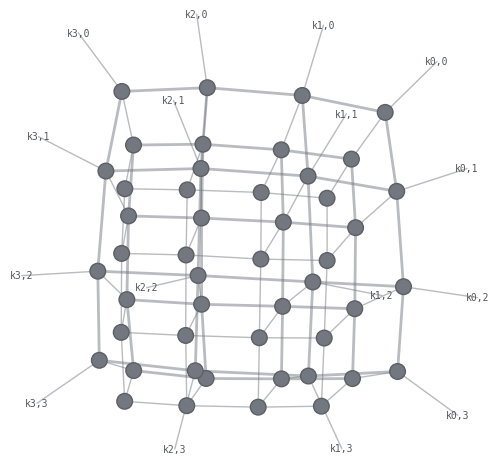

In [74]:
circuit_tnf.draw()